In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict, Counter
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
import lightgbm as lgb
import datatable as dt
from category_encoders import TargetEncoder
import optuna
import warnings
warnings.filterwarnings('ignore')

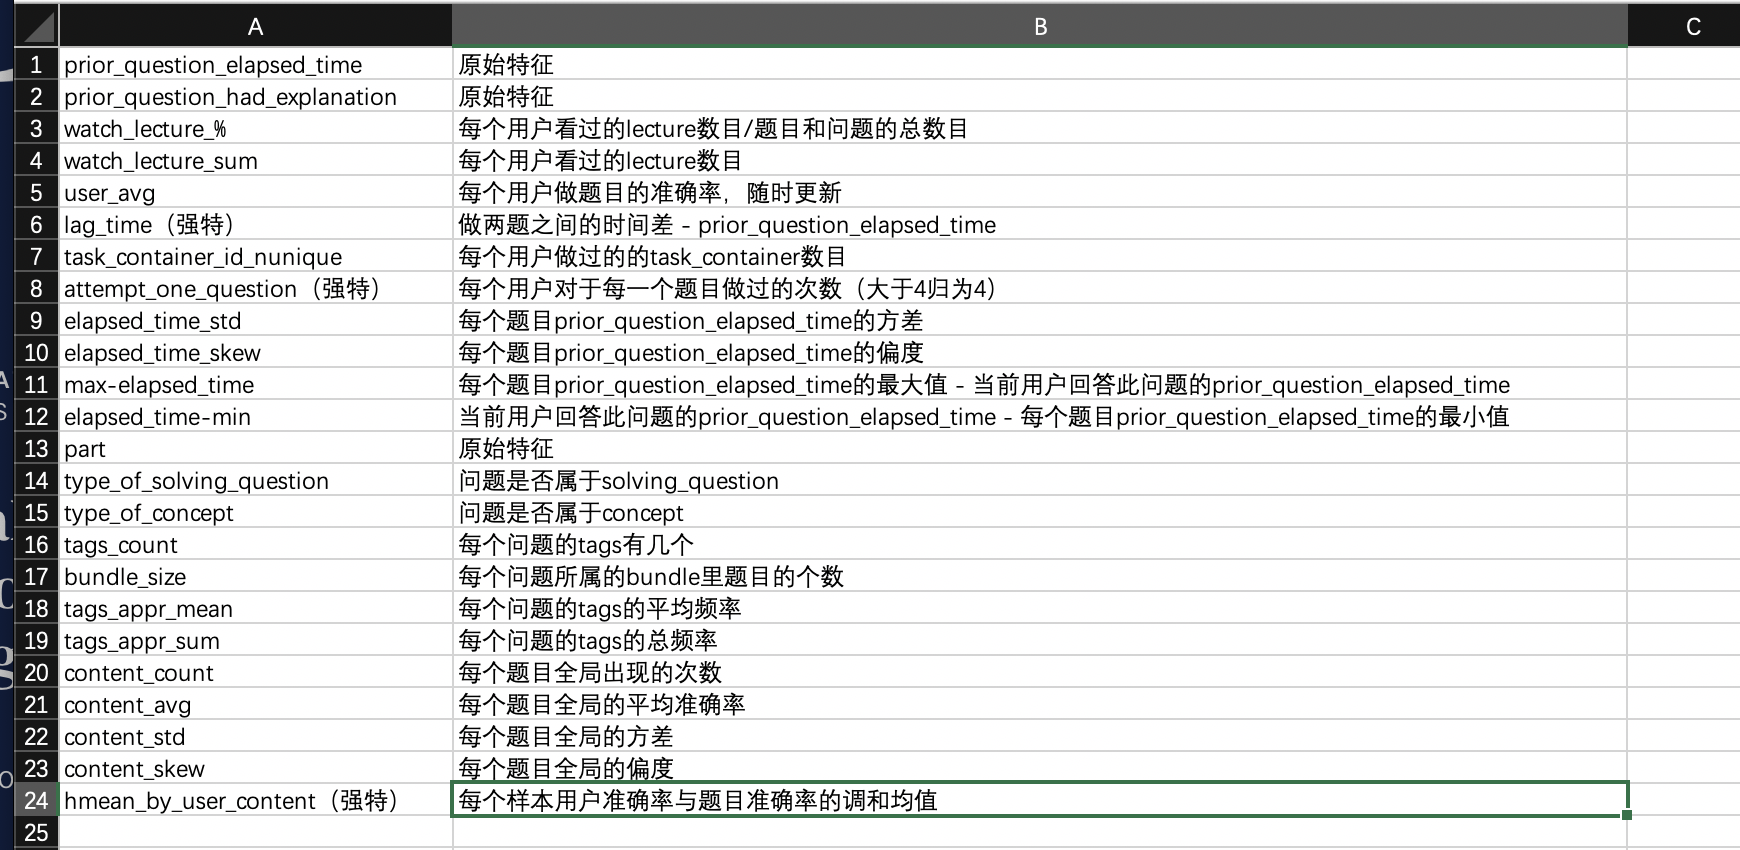

In [2]:
dir_path = '/home/zuoyuhui/datasets/riid准确回答/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [3]:
debug = True
if debug:
    nrows =300 * 10000
else:
    nrows = None

In [4]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'answered_correctly': 'int8',
    'user_answer': 'int8',
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}

train_size = 10
valid_size = 2
target = 'answered_correctly'

In [5]:
def clear_mem():
    %reset -f out
    %reset -f in
    gc.collect()

datatable.
fread
(
anysource=None, *, file=None, text=None, cmd=None, url=None, columns=None, sep=None, dec=".", max_nrows=None, header=None, na_strings=None, verbose=False, fill=False, encoding=None, skip_to_string=None, skip_to_line=0, skip_blank_lines=False, strip_whitespace=True, quotechar='"', tempdir=None, nthreads=None, logger=None, multiple_sources="warn", memory_limit=None)

In [6]:
%time
train_df = dt.fread(dir_path+file_train, max_nrows=nrows,columns=set(data_types_dict.keys())).to_pandas()

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.7 µs


In [7]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

# 特征提取
## train侧

In [8]:
# https://www.kaggle.com/zzuuoo2019ok/tabnet-fastai-linear-lgb-ensemble/edit/run/48871060
# user_correctness
train_df['lag'] = train_df.groupby('user_id')[target].shift()
train_df['lag'].fillna(0, inplace=True)
cum = train_df.groupby(['user_id'])['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)
del cum

In [9]:
user_watch_lecture_agg = train_df.groupby(['user_id'])['content_type_id'].agg(['count','sum'])  #用户看讲座的数量 总和   3824

In [10]:
train_df = train_df[train_df[target]!=-1].reset_index(drop=True)  # 排除讲座
prior_question_elapsed_time_avg = train_df['prior_question_elapsed_time'].dropna().values.mean()  # 用户解决问题平均时间 25302.957

In [11]:
# 用户历史回答问题正确数量、加和
user_agg = train_df.groupby(['user_id'])[target].agg(['sum','count'])  

In [12]:
# 问题正确 加和、数量、标准差、 偏度
content_agg = train_df.groupby(['content_id'])[target].agg(['sum','count','std','skew'])

In [13]:
# 问题回答时间 加和、数量、标准差、 偏度
time_content_agg = train_df.groupby('content_id')['prior_question_elapsed_time'].agg(['max', 'min', 'std', 'skew'])

In [14]:
# 用户的最后一次答题时间
user_timestamp_agg = train_df.groupby(['user_id'])['timestamp'].tail()

In [15]:
#  看该序列(axis=0/1对应着列或行)的不同值的数量
task_container_agg = train_df.groupby('user_id')['task_container_id'].nunique()

In [16]:
train_df = train_df.groupby('user_id').tail(train_size).reset_index(drop=True) # 大于十条的数据
print(train_df.shape)

(38159, 10)


In [18]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness
0,1359412,115,7897,0,36,3,0,17000.0,True,0.722222
1,1415188,115,7882,0,37,2,1,20000.0,True,0.702703
2,1468285,115,7962,0,38,3,1,17000.0,True,0.710526
3,667861680,115,1278,0,39,3,1,21000.0,False,0.717949
4,667971812,115,2065,0,40,2,1,17000.0,False,0.725000


In [16]:
clear_mem()

Flushing output cache (0 entries)
Flushing input history


## question侧

In [17]:
%time
question_dtype={
    'question_id': 'int16',
    'bundle_id': 'int16', 
    'correct_answer': 'int8',
    'part': 'int8',
    'tags': 'str'
}
questions = dt.fread(
    dir_path+file_questions,
    max_nrows=nrows,
    columns=set(question_dtype.keys())
).to_pandas()
questions = questions.astype(question_dtype)

lecture_dtype={
    'lecture_id': 'int16',
    'tag': 'int16',
    'part': 'int8',
    'type_of': 'str'
}
lecture = dt.fread(
    dir_path+file_lectures,
    max_nrows=nrows,
    columns=set(lecture_dtype.keys())
).to_pandas()
lecture = lecture.astype(lecture_dtype)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 22.9 µs


In [18]:
def question_type_of(x):
    types = []
    for i in x:
        if i in set(lecture['tag'].tolist()):
            des = list(lecture.loc[lecture['tag']==i, 'type_of'])
            types.extend(des)
        else:
            continue
    return types

In [19]:
tags = questions["tags"].str.split(" ", n=10, expand=False)
tags[10033] = ['162']
questions['tags'] = tags

def str_to_int(x):
    result = []
    for i in x:
        result.append(int(i))
    return set(result)

questions['tags'] = questions['tags'].apply(str_to_int)

questions['question_type_of'] = questions['tags'].apply(question_type_of)

In [36]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags,question_type_of,type_of_solving_question,type_of_concept,tags_count,bundle_size,tags_appr_mean,tags_appr_sum,tags_appr_most
0,0,0,0,1,"{162, 51, 131, 38}","[concept, solving question]",1,1,4,1,973.000000,3892,2256
1,1,1,1,1,"{81, 131, 36}","[solving question, solving question, concept, ...",3,1,3,1,884.666667,2654,1969
2,2,2,0,1,"{162, 131, 92, 101}","[solving question, solving question, solving q...",3,1,4,1,971.500000,3886,2269
3,3,3,0,1,"{29, 162, 131, 149}","[solving question, solving question, solving q...",3,1,4,1,831.250000,3325,1707
4,4,4,3,1,"{162, 131, 5, 38}","[concept, solving question]",1,1,4,1,976.500000,3906,2256


In [38]:
lecture.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [21]:
questions['type_of_solving_question'] = questions['question_type_of'].apply(lambda x: x.count('solving question')) # solving question数量
questions['type_of_concept'] = questions['question_type_of'].apply(lambda x: x.count('concept')) #  concept 数量

In [23]:
questions['tags_count'] = questions['tags'].apply(lambda x: len(x)) # tags中数量

In [32]:
tags_list = []
for tag in questions['tags'].tolist():
    tags_list.extend(list(tag))
tags_counter = dict(Counter(tags_list))

bundle_dict = questions['bundle_id'].value_counts().to_dict()
questions['bundle_size'] = questions['bundle_id'].apply(lambda x : bundle_dict[x])

In [34]:
def tag_appr_means(tags):
    l=[]
    for tag in tags:
        l.append(tags_counter[tag])
    return np.mean(l)

def tag_appr_sum(tags):
    l=[]
    for tag in tags:
        l.append(tags_counter[tag])
    return np.sum(l)

def tag_appr_most(tags):
    tag_max = 0
    for tag in tags:
        if tags_counter[tag]>tag_max:
            tag_max = tags_counter[tag]
        else:
            continue
    return tag_max

In [35]:
questions['tags_appr_mean'] = questions['tags'].apply(tag_appr_means) # tags均值
questions['tags_appr_sum'] = questions['tags'].apply(tag_appr_sum)  # tags加和
questions['tags_appr_most'] = questions['tags'].apply(tag_appr_most) # tags最大值

In [37]:
# 合并
questions.set_index('question_id', inplace=True)
train_df = train_df.join(questions, on=['content_id'], how="left")

In [38]:
del train_df
clear_mem()

Flushing output cache (8 entries)
Flushing input history


In [ ]:
feats = ['prior_question_elapsed_time', 'prior_question_had_explanation', 
         'watch_lecture_%',
         'watch_lecture_sum', 
         'user_avg', 
         'lag_time',
         'task_container_id_nunique',
         'attempt_one_question', 
         'elapsed_time_std', 'elapsed_time_skew', 'max-elapsed_time', 
         'elapsed_time-min', 'part', 'type_of_solving_question', 'type_of_concept', 
         'tags_count', 'bundle_size', 'tags_appr_mean', 'tags_appr_sum', 
         #'only_tag',
         #'is_162', 'tag_alone', 
         'content_count', 'content_avg', 'content_std', 'content_skew', 
         'hmean_by_user_content'
        ]

In [19]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))
user_watch_lecture_sum_dict = user_watch_lecture_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_watch_lecture_count_dict = user_watch_lecture_agg['count'].astype('int16').to_dict(defaultdict(int))
user_timestamp_dict = user_timestamp_agg.to_dict(defaultdict(int))
task_container_dict = task_container_agg.to_dict(defaultdict(int))

clear_mem()

Flushing output cache (1 entries)
Flushing input history


In [ ]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_bin': 700,
    'learning_rate': 0.05,
}

lgb_train = lgb.Dataset(X, y, categorical_feature=['part', 'prior_question_had_explanation'])
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature=['part', 'prior_question_had_explanation'], reference=lgb_train)